In [1794]:
# import torch
import numpy as np
import matplotlib.pyplot as plt
# import torch.nn as nn
# import torch.nn.functional as F
import pickle as pkl
# from torch_geometric.utils import dense_to_sparse
# import torch_geometric
# from torch_geometric.nn import GCNConv,GATConv
from tqdm import tqdm
import wandb
import random
from model import *

In [1795]:
class Normalization_temp(nn.Module):
    def __init__(self, group_size=2, input_dim=3, output_dim=3):
        super(Normalization_temp, self).__init__()
        # Modify the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels=input_dim, out_channels=16, kernel_size=group_size, stride=group_size),#ke
            nn.ReLU(),
        ) 
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels=input_dim, out_channels=16, kernel_size=group_size, stride=group_size),
            nn.ReLU(),
        )
        self.mlp1 = nn.Linear(16,3)
        self.mlp2 = nn.Linear(16,3)
    def forward(self, x):
        return x
    def Encoder(self,x):
        b,t,l,_,f = x.shape
        x = x.permute(0, 4, 1, 2, 3) #b*t*f*l*l
        x = self.encoder(x)
        x = x.permute(0, 2, 3, 4, 1)#b*t*l*l*f
        x = self.mlp1(x)
        return x
    def Decoder(self,x):
        b,t,l,_,f = x.shape
        x = x.permute(0, 4, 1, 2, 3)
        x = self.decoder(x)
        x = x.permute(0, 2, 3, 4, 1)
        x = self.mlp2(x)
        return x
    
    
class Normalization_temp(nn.Module):
    def __init__(self, group_size=(2,2), input_dim=3, output_dim=3):
        super(Normalization_temp, self).__init__()
        # Modify the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels=input_dim, out_channels=16, 
                      kernel_size=(group_size[0],group_size[1],group_size[1]),
                      stride=(group_size[0],group_size[1],group_size[1])),#ke
            nn.ReLU(),
        ) 
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels=input_dim, out_channels=16,
                               kernel_size=(group_size[0],group_size[1],group_size[1]),
                               stride=(group_size[0],group_size[1],group_size[1])),
            nn.ReLU(),
        )
        self.mlp1 = nn.Linear(16,3)
        self.mlp2 = nn.Linear(16,3)
    def forward(self, x):
        return x
    def Encoder(self,x):
        b,t,l,_,f = x.shape
        x = x.permute(0, 4, 1, 2, 3) #b*t*f*l*l
#         print(x.shape)
#         de
        x = self.encoder(x)
        x = x.permute(0, 2, 3, 4, 1)#b*t*l*l*f
        x = self.mlp1(x)
        return x
    def Decoder(self,x):
        b,t,l,_,f = x.shape
        x = x.permute(0, 4, 1, 2, 3)
        x = self.decoder(x)
        x = x.permute(0, 2, 3, 4, 1)
        x = self.mlp2(x)
        return x

In [115]:
# etas = [0.5,1,1.5,1.8,2]
# for eta in etas:
etas=[1,1.25,1.5,1.75,2]
eta = 1.75
seed = 2051
# with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=32_field_{seed}.pkl','rb') as f:
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_field_{2050}.pkl','rb') as f:
    data = pkl.load(f)
    field = data['field']

    '输入1步，预测1步，将原始数据b,t,L,L,f转化为b,t,t\',L,L,f的格式，xt\' = 5,yt\'=1'
print(field.shape)
n_steps_in, n_steps_out = (16,2)#(2,2) #

# 将数据转换为输入和输出格式
data_x, data_y = [], []
for i in tqdm(range(field.shape[1]  - n_steps_in - n_steps_out + 1)):
#     for i in range(data.shape[0] - n_steps_in - n_steps_out + 1):
    data_x.append(field[:,i:i+n_steps_in])
    data_y.append(field[:,i+n_steps_in:i+n_steps_in+n_steps_out,:,:,:])
data_x, data_y = np.array(data_x), np.array(data_y)

data_x = torch.tensor(data_x,dtype=torch.float)
data_y = torch.tensor(data_y,dtype=torch.float)

data_x = torch.transpose(data_x,0,1)
data_y = torch.transpose(data_y,0,1)
print(data_y.shape,data_x.shape)

L = field.shape[-2]
data_x = data_x.reshape(-1,n_steps_in,L,L,3)
data_y = data_y.reshape(-1,n_steps_out,L,L,3)
batch_size = 32
data_x.shape,data_y.shape



batch_size=10

# test_data_x = data_x[int(0.8*data_x.shape[0]):,:,:,:]
# test_data_y = data_y[int(0.8*data_x.shape[0]):,:,:,:]
random.seed(0)
random_indexs = np.random.choice(data_x.shape[0],1000)
test_data_x = data_x[random_indexs]
test_data_y = data_y[random_indexs]

dataset3 = torch.utils.data.dataset.TensorDataset(test_data_x, test_data_y)
test_loader1 = torch.utils.data.DataLoader(dataset=dataset3,
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           drop_last=False)
# seed = 2050
group_size = (4,2)#(2,2)#
# dynamic = torch.load(f'./models/307/field_dynamic_n=307_eta={eta}_seed={seed}.pth')
# dynamic = torch.load(f'../../models/vicsek/field_dynamic_n=307_0505_eta={eta}.pth')
models = torch.load(f'./models/307/renorm=307_eta={eta}_gz={group_size}_seed={seed}.pth')
# models = torch.load(f'./models/1228/renorm=1228_eta={eta}_gz={group_size}_seed={seed}.pth')
dynamic = models['dynamic']
renorm = models['renorm']

(10, 300, 64, 64, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 752210.41it/s]


torch.Size([10, 283, 2, 64, 64, 3]) torch.Size([10, 283, 16, 64, 64, 3])


In [116]:
NEAR_0 = 1e-10
# loss_F = torch.nn.NLLLoss()
loss_F = torch.nn.MSELoss()
test_data_x.shape

torch.Size([1000, 16, 64, 64, 3])

In [1082]:
def normalized(data,mean,std):
    return (data - mean) / std

def SMAPE(data,predict):
    return torch.mean(abs(data - predict)/(abs(data)+abs(predict))/2)
def MSE(data,predict):
#     indexs = np.where(data!=0)
#     data = data[indexs]
#     predict = predict[indexs]
    return torch.mean((data - predict)**2)
#     return torch.mean(torch.abs((data - predict))) #mae

def MAE(data,predict):
    indexs = np.where(data!=0)
    data = data[indexs]
    predict = predict[indexs]
    return torch.mean(torch.abs((data - predict)))

## encoder once-L=32,64,group_size=(2,2) / (4,2)

In [886]:
'两次encoder'
'看宏观态预测'
losst_pred = []
losst_pred1 = []
losst_pred2 = []
losst_pred3 = []

losst_decoder = []
losst_decoder1 = []
losst_decoder2 = []
losst_decoder3 = []

losst_marco = []
losst_marco1 = []
losst_marco2 = []
losst_marco3 = []

dynamic.eval()
renorm.eval()

data_values = []
pred_values = []
decoder_values = []
encoder2_values = []
marco_pred_values = []
count = 0

# group_size = 2
# temp_size=3
last_time_series = 5

for datax,datay in tqdm(test_loader1):
#     print(datax.shape,datay.shape)
    pred = dynamic(datax[:,-1:,:,:,:]).detach()

    encoder11 = renorm.Encoder(datax)
#     print(datax.shape,encoder11.shape)
    encoder12 = renorm.Encoder(encoder11)
    
#     encoder21 = renorm.Encoder(datay)
#     encoder22 = renorm.Encoder(encoder21)

    macro_pred = dynamic(encoder12)
    decoder1 = renorm.Decoder(macro_pred)
    decoder2 = renorm.Decoder(decoder1)[:,:2,:,:,:] #不同粗粒化的预测步数不同，要统一
#     print(decoder2.shape)
#     de
    
    data_values.extend(list(np.mean(datay.numpy().reshape(len(datax),-1,3),axis=1)))
    pred_values.extend(list(np.mean(pred.numpy().reshape(len(datax),-1,3),axis=1)))
#     encoder2_values.extend(list(np.mean(encoder22.detach().numpy().reshape(len(datax),-1,3),axis=1)))
    decoder_values.extend(list(np.mean(decoder2.detach().numpy().reshape(len(datax),-1,3),axis=1)))
#     marco_pred_values.extend(list(np.mean(macro_pred.detach().numpy().reshape(len(datax),-1,3),axis=1)))

#     print(pred.shape,datay.shape)
    loss = MSE(pred.reshape(-1), datay[:,0:1,:,:,:].reshape(-1))
    
    'micro prediction loss'
    losst_pred.append(loss.item())
    
    loss = MSE(pred[:,:,:,:,0].reshape(-1), datay[:,0:1,:,:,0].reshape(-1))
    losst_pred1.append(loss.item())
    loss = MSE(pred[:,:,:,:,1].reshape(-1), datay[:,0:1,:,:,1].reshape(-1))
    losst_pred2.append(loss.item())
    loss = MSE(pred[:,:,:,:,2].reshape(-1), datay[:,0:1,:,:,2].reshape(-1))
    losst_pred3.append(loss.item())
    
    'decoder loss'
    loss = MSE(decoder2.reshape(-1), datay.reshape(-1))
    losst_decoder.append(loss.item())
    loss = MSE(decoder2[:,:,:,:,0].reshape(-1), datay[:,:,:,:,0].reshape(-1))
    losst_decoder1.append(loss.item())
    loss = MSE(decoder2[:,:,:,:,1].reshape(-1), datay[:,:,:,:,1].reshape(-1))
    losst_decoder2.append(loss.item())
    loss = MSE(decoder2[:,:,:,:,2].reshape(-1), datay[:,:,:,:,2].reshape(-1))
    losst_decoder3.append(loss.item())
    
#     'macro loss'
#     loss = MSE(encoder22.reshape(-1), macro_pred.reshape(-1))
#     losst_marco.append(loss.item())
#     loss = MSE(encoder22[:,:,:,:,0].reshape(-1), macro_pred[:,:,:,:,0].reshape(-1))
#     losst_marco1.append(loss.item())
#     loss = MSE(encoder22[:,:,:,:,1].reshape(-1), macro_pred[:,:,:,:,1].reshape(-1))
#     losst_marco2.append(loss.item())
#     loss = MSE(encoder22[:,:,:,:,2].reshape(-1), macro_pred[:,:,:,:,2].reshape(-1))
#     losst_marco3.append(loss.item())
    
    count += 1
    


  0%|                                                                                                                        | 0/30 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (1 x 32 x 32). Kernel size: (4 x 2 x 2). Kernel size can't be greater than actual input size

In [119]:
group_size,seed,L,eta

((4, 2), 2051, 64, 1.75)

In [120]:
with open(f'./data/mse/mse_renorm2_eta={eta}_gz={group_size}_{seed}_L={L}','wb') as f:
    pkl.dump({
        'pred':[losst_pred,losst_pred1,losst_pred2,losst_pred3],
        'decoder':[losst_decoder,losst_decoder1,losst_decoder2,losst_decoder3],
        'macro':[losst_marco,losst_marco1,losst_marco2,losst_marco3],
    },f)

In [121]:
print(f'{np.mean([i for i in losst_pred1 if np.isnan(i)==False]):.5f}, {np.mean([i for i in losst_decoder1 if np.isnan(i)==False]):.5f}, {np.mean(losst_marco1):.5f}')
print(f'{np.mean(losst_pred2):.5f}, {np.mean(losst_decoder2):.5f}, {np.mean(losst_marco2):.5f}')
print(f'{np.mean([i for i in losst_pred3 if np.isnan(i)==False]):.5f}, {np.mean(losst_decoder3):.5f}, {np.mean(losst_marco3):.5f}')
print()
print(f'{np.mean([i for i in losst_pred if np.isnan(i)==False]):.5f}, {np.mean([i for i in losst_decoder if np.isnan(i)==False]):.5f}, {np.mean(losst_marco):.5f}')
eta,group_size

0.17855, 0.45061, nan
0.11805, 0.23504, nan
0.11957, 0.23951, nan

0.13872, 0.30839, nan


(1.75, (4, 2))

In [ ]:
'encoder two times,L=64'
'group_size=1:1:1'
'''1'''
0.18314, 0.44881, 0.00867
0.09656, 0.19169, 0.00514
0.12013, 0.26630, 0.00793

0.13328, 0.19169, 0.00724
--

0.17600, 0.47732, 0.00474
0.09709, 0.23209, 0.00418
0.10720, 0.26810, 0.00323

0.12677, 0.23209, 0.00405
'''1.5'''
0.17627, 0.42679, 0.00577
0.09865, 0.17028, 0.00346
0.12273, 0.35900, 0.00437

0.13255, 0.17028, 0.00453
--
0.17612, 0.47271, 0.00455
0.10075, 0.25352, 0.00410
0.10464, 0.25676, 0.00315

0.12717, 0.25352, 0.00393

'''2'''
0.17642, 0.45447, 0.00134
0.12223, 0.22075, 0.00022
0.12325, 0.24505, 0.00218

0.14063, 0.22075, 0.00125
--
0.17965, 0.40715, 0.00438
0.12706, 0.22920, 0.00553
0.12761, 0.22602, 0.00461

0.14477, 0.22920, 0.00484

'''2.5'''
0.17356, 0.37250, 0.00134
0.13141, 0.19298, 0.00056
0.13130, 0.19278, 0.00201

0.14542, 0.19298, 0.00130
--
0.17501, 0.37155, 0.00168
0.13155, 0.19257, 0.00310
0.13138, 0.19274, 0.00072

0.14598, 0.19257, 0.00183

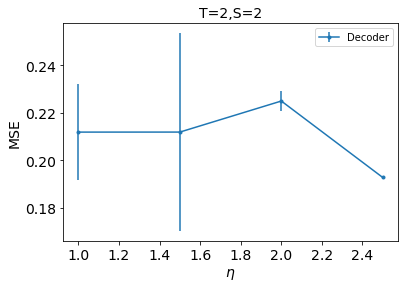

In [166]:
etas = [1,1.5,2,2.5]
'gz=(2,2),L=64,model is trained by L=64 and encoder twice'
# etas=[1,1.25,1.5,1.75,2]

micro = [[0.13319,0.13328],[0.13256,0.13255],[0.14066,0.14063],[0.14596,0.14542]]
decoder = [[0.23209,0.19169],[0.25352,0.17028],[0.22920,0.22075],[0.19257,0.19298]]
macro = [[0.01161,0.00724],[0.00957,0.00453],[0.00981,0.00125],[0.00832,0.00130]]
# plt.errorbar(etas,[np.mean(i) for i in vs_1],yerr=[np.std(i) for i in vs_1],marker='.',label='micro-vx')
# plt.errorbar(etas,[np.mean(i) for i in vs_2],yerr=[np.std(i) for i in vs_2],marker='s',label='micro-vy')
# plt.errorbar(etas,[np.mean(i) for i in dens],yerr=[np.std(i) for i in dens],marker='s',label='micro-density')
# plt.errorbar(etas,[np.mean(i) for i in micro],yerr=[np.std(i) for i in micro],marker='s',label='micro')
plt.errorbar(etas,[np.mean(i) for i in decoder],yerr=[np.std(i) for i in decoder],marker='.',label='Decoder')
# plt.errorbar(etas,[np.mean(i) for i in macro],yerr=[np.std(i) for i in macro],marker='*',label='macro')
plt.legend()
plt.title('T=2,S=2',fontsize=14)
set_plot_basicinf('MSE',r'$\eta$',14)
plt.show()


In [1828]:
def MSE(data,predict):
#     indexs = np.where(data!=0)
#     data = data[indexs]
#     predict = predict[indexs]
    return torch.mean((data - predict)**2,axis=-1)
#     return torch.mean(torch.abs((data - predict))) #mae

In [1829]:
'prediction result'
etas=[1,1.25,1.5,1.75,2,2.25]
MSE_prediction = []
for eta in etas:
    seed =2050
    with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=16_field_{seed}_test.pkl','rb') as f:
#     with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_pdf_{seed}.pkl','rb') as f:
        data = pkl.load(f)
    field = data['field'].mean(0)[:,np.newaxis,:,:,:]
    print(field.shape)
#     de
    b = field.shape[0]-1
    field = torch.tensor(field,dtype=torch.float)
    seed = 2051
#     dynamic= torch.load(f'./models/78/field_dynamic_n=78_eta={eta}_seed={seed}_pdf.pth')
    dynamic= torch.load(f'./models/78/field_dynamic_n=78_eta={eta}_seed={seed}.pth')
    pred = dynamic(field[:-1,:,:,:,:]).detach()
    mse = MSE(pred.reshape(b,-1), field[1:,:,:,:,:].reshape(b,-1))
#     print(mse.shape)
#     de
    MSE_prediction.append(mse)
    print(pred.shape)
    print(f'eta={eta},mse={torch.mean(mse):.5f}')


(500, 1, 16, 16, 3)
torch.Size([499, 1, 16, 16, 3])
eta=1,mse=0.00285
(500, 1, 16, 16, 3)
torch.Size([499, 1, 16, 16, 3])
eta=1.25,mse=0.00199
(500, 1, 16, 16, 3)
torch.Size([499, 1, 16, 16, 3])
eta=1.5,mse=0.00194
(500, 1, 16, 16, 3)
torch.Size([499, 1, 16, 16, 3])
eta=1.75,mse=0.00190
(500, 1, 16, 16, 3)
torch.Size([499, 1, 16, 16, 3])
eta=2,mse=0.00189
(500, 1, 16, 16, 3)
torch.Size([499, 1, 16, 16, 3])
eta=2.25,mse=0.00181


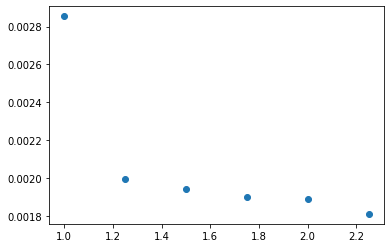

In [1830]:
plt.scatter(etas,[i.mean() for i in MSE_prediction])

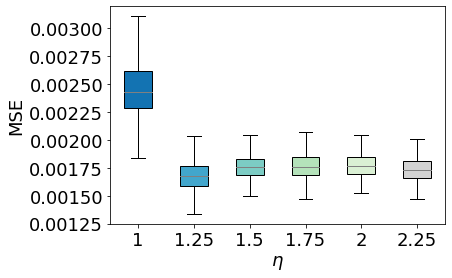

In [1831]:
ax = plt.boxplot(MSE_prediction,patch_artist=True,showfliers=False,
            boxprops=boxprops,
            medianprops = medianprops)
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)

set_plot_basicinf('MSE',r'$\eta$',fontsize)
plt.xticks([1,2, 3,4,5,6], etas,fontsize=fontsize)
plt.show()

In [1994]:
# etas = [0.5,1,1.5,1.8,2]
# for eta in etas:
etas=[1,1.25,1.5,1.75,2]
eta = 1.25
seed = 2050
L = 64
# with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=32_field_{seed}.pkl','rb') as f:
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_field_{2050}.pkl','rb') as f:
    data = pkl.load(f)
    field = data['field']#.mean(0)[np.newaxis,:]

    '输入1步，预测1步，将原始数据b,t,L,L,f转化为b,t,t\',L,L,f的格式，xt\' = 5,yt\'=1'
print(field.shape)
n_steps_in, n_steps_out = (4,4)#(2,2) #

# 将数据转换为输入和输出格式
data_x, data_y = [], []
for i in tqdm(range(field.shape[1]  - n_steps_in - n_steps_out + 1)):
#     for i in range(data.shape[0] - n_steps_in - n_steps_out + 1):
    data_x.append(field[:,i:i+n_steps_in])
    data_y.append(field[:,i+n_steps_in:i+n_steps_in+n_steps_out,:,:,:])
data_x, data_y = np.array(data_x), np.array(data_y)

data_x = torch.tensor(data_x,dtype=torch.float)
data_y = torch.tensor(data_y,dtype=torch.float)

data_x = torch.transpose(data_x,0,1)
data_y = torch.transpose(data_y,0,1)
print(data_y.shape,data_x.shape)

L = field.shape[-2]
data_x = data_x.reshape(-1,n_steps_in,L,L,3)
data_y = data_y.reshape(-1,n_steps_out,L,L,3)
data_x.shape,data_y.shape



batch_size=1

test_data_x = data_x[int(0.8*data_x.shape[0]):,:,:,:]
test_data_y = data_y[int(0.8*data_x.shape[0]):,:,:,:]
# random.seed(0)
# random_indexs = np.random.choice(data_x.shape[0],1000)
# test_data_x = data_x#[random_indexs]
# test_data_y = data_y#[random_indexs]

dataset3 = torch.utils.data.dataset.TensorDataset(test_data_x, test_data_y)
test_loader1 = torch.utils.data.DataLoader(dataset=dataset3,
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           drop_last=False)
# seed = 2050
group_size = (4,2)#
# dynamic = torch.load(f'./models/307/field_dynamic_n=307_eta={eta}_seed={seed}.pth')
# dynamic = torch.load(f'../../models/vicsek/field_dynamic_n=307_0505_eta={eta}.pth')
# models = torch.load(f'./models/307/renorm=307_eta={eta}_gz={group_size}_seed={seed}.pth')
lam = 0.5
models = torch.load(f'./models/78/renorm=78_eta={eta}_gz={group_size}_seed={seed}_lambda={lam}.pth')
# models = torch.load(f'./models/1228/renorm=1228_eta={eta}_gz={group_size}_seed={seed}.pth')
dynamic = models['dynamic']
renorm = models['renorm']

(10, 300, 64, 64, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 445264.88it/s]


torch.Size([10, 293, 4, 64, 64, 3]) torch.Size([10, 293, 4, 64, 64, 3])


## encoder once-L=32,64,group_size=(2,2) / (4,2)

In [1995]:
len(test_loader1)

586

In [1996]:
# '看宏观态预测'
losst_pred = []
losst_pred1 = []
losst_pred2 = []
losst_pred3 = []

losst_decoder = []
losst_decoder1 = []
losst_decoder2 = []
losst_decoder3 = []

losst_marco = []
losst_marco1 = []
losst_marco2 = []
losst_marco3 = []

dynamic.eval()
renorm.eval()

data_values = []
pred_values = []
decoder_values = []
encoder2_values = []
marco_pred_values = []
count = 0

# group_size = 2
# temp_size=3
last_time_series = 5

for datax,datay in tqdm(test_loader1):
#     print(datax.shape,datay.shape)
#     de
    pred = dynamic(datax[:,-1:,:,:,:]).detach()

    encoder1 = renorm.Encoder(datax)
    encoder2 = renorm.Encoder(datay)
    encoder1[:,:,:,:,0] = encoder1[:,:,:,:,0]
    encoder2[:,:,:,:,0] = encoder2[:,:,:,:,0]
    
    macro_pred = dynamic(encoder1)
    decoder = renorm.Decoder(macro_pred)[:,:2,:,:,:].detach() #不同粗粒化的预测步数不同，要统一
    
    
    data_values.extend(list(np.mean(datay.numpy().reshape(len(datax),-1,3),axis=1)))
    pred_values.extend(list(np.mean(pred.numpy().reshape(len(datax),-1,3),axis=1)))
    encoder2_values.extend(list(np.mean(encoder2.detach().numpy().reshape(len(datax),-1,3),axis=1)))
    decoder_values.extend(list(np.mean(decoder.detach().numpy().reshape(len(datax),-1,3),axis=1)))
    marco_pred_values.extend(list(np.mean(macro_pred.detach().numpy().reshape(len(datax),-1,3),axis=1)))

#     print(pred[0,:1,:,:,0],datay[0,:1,:,:,0])
    loss = MSE(pred.reshape(-1), datay[:,0:1,:,:,:].reshape(-1))

    losst_pred.append(loss.item())
    
    loss = MSE(pred[:,:,:,:,0].reshape(-1), datay[:,0:1,:,:,0].reshape(-1))
    losst_pred1.append(loss.item())
    loss = MSE(pred[:,:,:,:,1].reshape(-1), datay[:,0:1,:,:,1].reshape(-1))
    losst_pred2.append(loss.item())
    loss = MSE(pred[:,:,:,:,2].reshape(-1), datay[:,0:1,:,:,2].reshape(-1))
    losst_pred3.append(loss.item())
    
    loss = MSE(decoder.reshape(-1), datay[:,:2,:,:,:].reshape(-1))
    losst_decoder.append(loss.item())
    loss = MSE(decoder[:,:,:,:,0].reshape(-1), datay[:,:2,:,:,0].reshape(-1))
    losst_decoder1.append(loss.item())
    loss = MSE(decoder[:,:,:,:,1].reshape(-1), datay[:,:2,:,:,1].reshape(-1))
    losst_decoder2.append(loss.item())
    loss = MSE(decoder[:,:,:,:,2].reshape(-1), datay[:,:2,:,:,2].reshape(-1))
    losst_decoder3.append(loss.item())
    
    loss = MSE(encoder2.reshape(-1), macro_pred.reshape(-1))
    losst_marco.append(loss.item())
    loss = MSE(encoder2[:,:,:,:,0].reshape(-1), macro_pred[:,:,:,:,0].reshape(-1))
    losst_marco1.append(loss.item())
    loss = MSE(encoder2[:,:,:,:,1].reshape(-1), macro_pred[:,:,:,:,1].reshape(-1))
    losst_marco2.append(loss.item())
    loss = MSE(encoder2[:,:,:,:,2].reshape(-1), macro_pred[:,:,:,:,2].reshape(-1))
    losst_marco3.append(loss.item())
    
    count += 1
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 586/586 [00:03<00:00, 166.51it/s]


In [1997]:

L,seed,eta,group_size,

(64, 2050, 1.25, (4, 2))

In [1998]:
# with open(f'./data/mse/mse_eta={eta}_gz={group_size}_{seed}_L={L}','wb') as f:
with open(f'./data/mse/mse_eta={eta}_gz={group_size}_{seed}_L={L}','wb') as f:
    pkl.dump({
        'pred':[losst_pred,losst_pred1,losst_pred2,losst_pred3],
        'decoder':[losst_decoder,losst_decoder1,losst_decoder2,losst_decoder3],
        'macro':[losst_marco,losst_marco1,losst_marco2,losst_marco3],
    },f)

In [1983]:
print(f'{np.mean([i for i in losst_pred1 if np.isnan(i)==False]):.5f}, {np.mean([i for i in losst_decoder1 if np.isnan(i)==False]):.5f}, {np.mean(losst_marco1):.5f}')
print(f'{np.mean(losst_pred2):.5f}, {np.mean(losst_decoder2):.5f}, {np.mean(losst_marco2):.5f}')
print(f'{np.mean([i for i in losst_pred3 if np.isnan(i)==False]):.5f}, {np.mean(losst_decoder3):.5f}, {np.mean(losst_marco3):.5f}')
print()
print(f'{np.mean([i for i in losst_pred if np.isnan(i)==False]):.5f}, {np.mean([i for i in losst_decoder if np.isnan(i)==False]):.5f}, {np.mean(losst_marco):.5f}')
eta,group_size

0.17617, 0.34545, 0.00971
0.12258, 0.18705, 0.01057
0.12286, 0.19571, 0.01158

0.14054, 0.24274, 0.01062


(2, (4, 2))

In [2007]:

group_size=(2,2)#(2,2)#
# seed = 2051
L=32
pred_loss = {}
decoder_loss = {}
macro_loss = {}
# for eta in [1,1.5,2]:
for eta in [1,1.25,1.5,1.75,2]:
    pred_loss[eta] = []
    decoder_loss[eta] = []
    macro_loss[eta] = []
    for seed in [2050]:
        with open(f'./data/mse/mse_eta={eta}_gz={group_size}_{seed}_L={L}','rb') as f:
#         with open(f'./data/mae/mae_eta={eta}_gz={group_size}_{seed}_L={L}_randomint','rb') as f:
#         with open(f'./data/mse_renorm2_eta={eta}_gz={group_size}_{seed}_L={L}','rb') as f:
            losses = pkl.load(f)
            pred_loss[eta].extend(losses['pred'][0])
            decoder_loss[eta].extend(losses['decoder'][0])
            macro_loss[eta].extend(losses['macro'][0])

In [2008]:
len(pred_loss[eta])

100

In [2009]:
def set_plot_basicinf(ylabel,xlabel,fontsize=14):
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.xlabel(xlabel,fontsize=fontsize)

In [2010]:
import seaborn as sns
colors = sns.color_palette('GnBu_r',5)#autumn
colors

[(0.07497116493656286, 0.4526874279123414, 0.6969319492502883),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.485121107266436, 0.801045751633987, 0.7677047289504038),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.8535178777393311, 0.9429757785467128, 0.8314186851211073)]

In [2011]:
etas = [1.25,1.5,1.75,2,2.25]
# etas = [1,1.25,1.5]
# etas = [1,1.5,2]
fontsize = 18

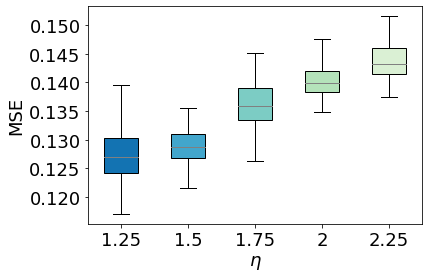

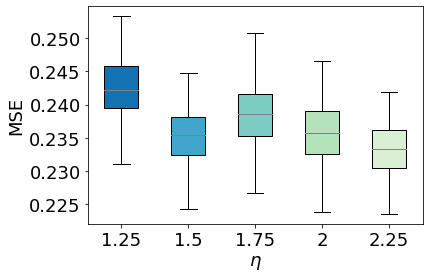

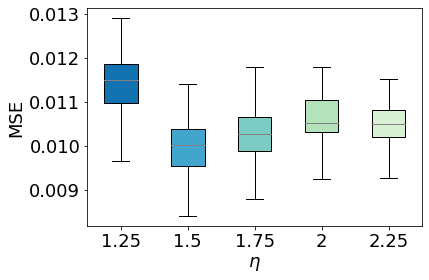

2050


In [2012]:
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
preds = [i for i in pred_loss.values()]
decoders = [i for i in decoder_loss.values()]
macros = [i for i in macro_loss.values()]

boxprops = dict(facecolor='lightgrey', color='black')
medianprops = dict(color='grey')
whiskerprops=dict(color='black')
capprops=dict(color='black')
labels = etas

'prediction'
ax = plt.boxplot(preds,patch_artist=True,showfliers=False,
            boxprops=boxprops,
            medianprops = medianprops)
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)

set_plot_basicinf('MSE',r'$\eta$',fontsize)
plt.xticks([1,2, 3,4,5], etas,fontsize=fontsize)
# plt.xticks([1,2,3], etas,fontsize=fontsize)
# plt.yticks([0.12,0.130,0.14,0.15])
# plt.title('不同状态的MSE误差分布')
plt.show()

'decoder'
ax = plt.boxplot(decoders,patch_artist=True,showfliers=False,
                boxprops=boxprops,
                medianprops = medianprops)
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)
set_plot_basicinf('MSE',r'$\eta$',fontsize)
plt.xticks([1,2,3,4,5], etas,fontsize=fontsize)
# plt.xticks([1,2,3], etas,fontsize=fontsize)
# plt.title('不同状态的MSE误差分布')
plt.show()

'macro'
ax = plt.boxplot(macros,patch_artist=True,showfliers=False,
            boxprops=boxprops,
            medianprops = medianprops)
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)
set_plot_basicinf('MSE',r'$\eta$',fontsize)
plt.xticks([1,2,3,4,5], etas,fontsize=fontsize)
# plt.xticks([1,2,3], etas,fontsize=fontsize)
# plt.title('不同状态的MSE误差分布')
plt.show()
print(seed)

In [1564]:
field[0,:]

(10, 300, 64, 64, 3)

In [1762]:
'create animation'
import imageio
etas=[1,1.25,1.5,1.75,2]

seed = 2050
# for eta in etas:
eta = 1.25
L=64
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L={L}_pdf_{seed}.pkl','rb') as f:
    data = pkl.load(f)
    field = data['field']
print(field.shape)

steps=30
for count in range(steps):
    plt.figure(dpi=100,figsize=(10,4))
    plt.subplot(131)
    plt.title(f'density')
    plt.imshow(field[count+30,:,:,0],cmap='GnBu_r',vmin=0)
#     plt.colorbar()
#     plt.imshow(field[count,:,:,0],cmap='GnBu_r')
    plt.subplot(132)
    plt.title(f'vx')
    plt.imshow(field[count+30,:,:,1],cmap='GnBu_r',vmin=0)
#     plt.imshow(field[0,count,:,:,1],cmap='GnBu_r')
    plt.subplot(133)
    plt.imshow(field[count+30,:,:,2],cmap='GnBu_r',vmin=0)
#     plt.imshow(field[0,count,:,:,2],cmap='GnBu_r')
    plt.title(f'vy')
    plt.suptitle(f'eta={eta},step={count}')
    plt.savefig(f'./img/temp/img_{count}_{eta}.png', 
        transparent = False,  
        facecolor = 'white'
       )

    plt.close()

frames = []
for i in range(steps):
    image = imageio.v2.imread(f'./img/temp/img_{i}_{eta}.png')
    frames.append(image)
imageio.mimsave(f'./img/L={L}_eta={eta}_rho=0.3.gif', # output gif
                frames,          # array of input frames
                fps = 4)


(100, 64, 64, 3)


In [1469]:
decoders[0][:10],decoders[-2][:10]

([0.29777994751930237,
  0.30044791102409363,
  0.2989053726196289,
  0.29870617389678955,
  0.29655104875564575,
  0.3016705811023712,
  0.29124319553375244,
  0.29748019576072693,
  0.29463857412338257,
  0.295986145734787],
 [0.2917604446411133,
  0.28818991780281067,
  0.2882205545902252,
  0.2876798212528229,
  0.287515789270401,
  0.28928327560424805,
  0.2932588756084442,
  0.2909562289714813,
  0.28627797961235046,
  0.2859130799770355])

## visualization data

In [1666]:
# etas = [0.5,1,1.5,1.8,2]
# for eta in etas:
etas=[1,1.25,1.5,1.75,2]
eta = 1
seed = 2050
# with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=32_field_{seed}.pkl','rb') as f:
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_field_{seed}.pkl','rb') as f:
    data = pkl.load(f)
    field = data['field'].mean(0)[:100,:,:,:]

    '输入1步，预测1步，将原始数据b,t,L,L,f转化为b,t,t\',L,L,f的格式，xt\' = 5,yt\'=1'


data = torch.tensor(field,dtype=torch.float)
print(data.shape)

# seed = 2050
group_size = (4,2)#

# models = torch.load(f'./models/307/renorm=307_eta={eta}_gz={group_size}_seed={seed}.pth')
models = torch.load(f'./models/78/renorm=78_eta={eta}_gz={group_size}_seed={seed}_lambda=0.9.pth')
# models = torch.load(f'./models/1228/renorm=1228_eta={eta}_gz={group_size}_seed={seed}.pth')
dynamic = models['dynamic']
renorm = models['renorm']

torch.Size([100, 64, 64, 3])


In [1667]:
fontsize=14

eta=1
pred mse: tensor(0.0112)
decoder mse: tensor(0.0132)
macro mse: tensor(0.0031)


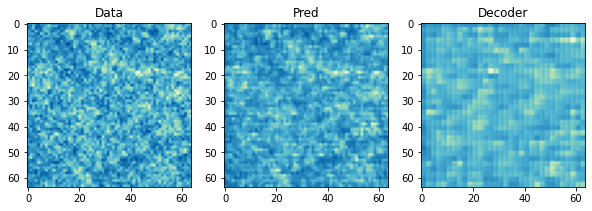

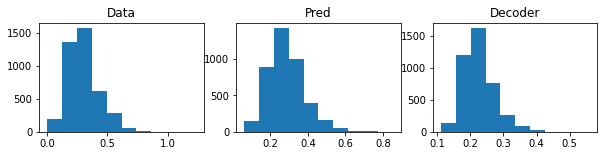

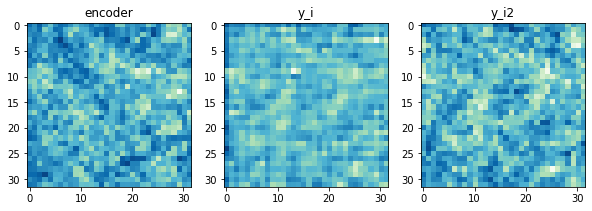

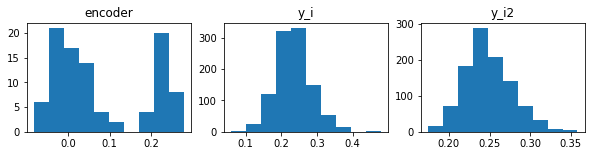

In [1668]:
fea_index= 0
# for datax,datay in tqdm(test_loader1):
#     print(datax.shape,datay.shape)
# step = 100
pred = dynamic(data[2:3,:,:,:].unsqueeze(0)).detach()
# pred[:,:,:,:,0] = torch.round(pred[:,:,:,:,0])
if group_size[0] == 4:
    encoder1 = renorm.Encoder(data[:4,:,:,:].unsqueeze(0)).detach()
    encoder2 = renorm.Encoder(data[4:8,:,:,:].unsqueeze(0)).detach()
else:
    encoder1 = renorm.Encoder(data[:2,:,:,:].unsqueeze(0)).detach()
    encoder2 = renorm.Encoder(data[2:4,:,:,:].unsqueeze(0)).detach()
# encoder1[:,:,:,:,0] = torch.round(encoder1[:,:,:,:,0])
# encoder2[:,:,:,:,0] = torch.round(encoder2[:,:,:,:,0])
#     print('encoder',encoder1.shape,encoder2.shape)
#     print('macro_pred',macro_pred.shape)
#     de
macro_pred = dynamic(encoder1).detach()
# macro_pred[:,:,:,:,0] = torch.round(macro_pred[:,:,:,:,0])
decoder = renorm.Decoder(macro_pred).detach()
# decoder[:,:,:,:,0] = torch.round(decoder[:,:,:,:,0])
#     print(pred.shape,decoder.shape)
print(f'eta={eta}')
print('pred mse:',MSE(data[2:3],pred))
print('decoder mse:',MSE(data[2:3],decoder[:,:1]))
print('macro mse:',MSE(macro_pred,encoder2))
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(data[3,:,:,fea_index],cmap='GnBu_r',vmin=torch.min(data[0,:,:,fea_index]))
plt.title('Data')

plt.subplot(132)
plt.imshow(pred[0,0,:,:,fea_index],cmap='GnBu_r',vmin=torch.min(data[0,:,:,fea_index]))
plt.title('Pred')

plt.subplot(133)
plt.imshow(decoder[0,0,:,:,fea_index],cmap='GnBu_r',vmin=torch.min(data[0,:,:,fea_index]))
plt.title('Decoder')

plt.show()

plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(data[2:3,:,:,fea_index].reshape(-1).numpy())
plt.title('Data')
#     de
plt.subplot(132)
plt.hist(pred[:,:,:,:,fea_index].reshape(-1).numpy())
plt.title('Pred')

plt.subplot(133)
plt.hist(decoder[:,:1,:,:,fea_index].reshape(-1).numpy())
plt.title('Decoder')

plt.show()

#     print(encoder1.shape,encoder2.shape,macro_pred.shape)
#     print(encoder1[0,0,:,0,fea_index])
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(encoder1[0,0,:,:,fea_index],cmap='GnBu_r',)
plt.title('encoder')

plt.subplot(132)
plt.imshow(macro_pred[0,0,:,:,fea_index],cmap='GnBu_r')
plt.title('y_i')

plt.subplot(133)
plt.imshow(encoder2[0,0,:,:,fea_index],cmap='GnBu_r')
plt.title('y_i2')
#     plt.suptitle('Order',fontweight='bold',fontsize=fontsize)
plt.show()

plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(encoder1[:,:,:,fea_index].reshape(-1).numpy())
plt.title('encoder')
#     de
plt.subplot(132)
plt.hist(macro_pred[:,:,:,:,fea_index].reshape(-1).numpy())
plt.title('y_i')

plt.subplot(133)
plt.hist(encoder2[:,:,:,:,fea_index].reshape(-1).numpy())
plt.title('y_i2')

plt.show()



In [1559]:
data[:,:,:,fea_index].shape

torch.Size([30, 64, 64])

In [1390]:

# eta = 2
# seed = 2050
# L = 16
# # with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=32_field_{seed}.pkl','rb') as f:
# with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_field_{seed}_test.pkl','rb') as f:
#     data = pkl.load(f)
#     field = data['field']

#     '输入1步，预测1步，将原始数据b,t,L,L,f转化为b,t,t\',L,L,f的格式，xt\' = 5,yt\'=1'
# print(field.shape)
# n_steps_in, n_steps_out = (4,4)#(2,2) #

# # 将数据转换为输入和输出格式
# data_x, data_y = [], []
# for i in tqdm(range(field.shape[1]  - n_steps_in - n_steps_out + 1)):
# #     for i in range(data.shape[0] - n_steps_in - n_steps_out + 1):
#     data_x.append(field[:,i:i+n_steps_in])
#     data_y.append(field[:,i+n_steps_in:i+n_steps_in+n_steps_out,:,:,:])
# data_x, data_y = np.array(data_x), np.array(data_y)

# data_x = torch.tensor(data_x,dtype=torch.float)
# data_y = torch.tensor(data_y,dtype=torch.float)

# data_x = torch.transpose(data_x,0,1)
# data_y = torch.transpose(data_y,0,1)
# print(data_y.shape,data_x.shape)

# L = field.shape[-2]
# data_x = data_x.reshape(-1,n_steps_in,L,L,3)
# data_y = data_y.reshape(-1,n_steps_out,L,L,3)
# data_x.shape,data_y.shape



# batch_size=10


# test_data_x = data_x#[random_indexs]
# test_data_y = data_y#[random_indexs]

# dataset3 = torch.utils.data.dataset.TensorDataset(test_data_x, test_data_y)
# test_loader1 = torch.utils.data.DataLoader(dataset=dataset3,
#                                            batch_size=batch_size, 
#                                            shuffle=False,
#                                            drop_last=False)
# # seed = 2050
# group_size = (4,2)#
# lam = 0.9
# models = torch.load(f'./models/78/renorm=78_eta={eta}_gz={group_size}_seed={seed}_lambda={lam}.pth')
# # models = torch.load(f'./models/1228/renorm=1228_eta={eta}_gz={group_size}_seed={seed}.pth')
# dynamic = models['dynamic']
# renorm = models['renorm']


for idx,(datax,datay) in enumerate(tqdm(test_loader1)):
#     print(datax.shape,datay.shape)
    pred = dynamic(datax[:,-1:,:,:,:]).detach()

    encoder1 = renorm.Encoder(datax)
    encoder2 = renorm.Encoder(datay)
    encoder1[:,:,:,:,0] = encoder1[:,:,:,:,0]
    encoder2[:,:,:,:,0] = encoder2[:,:,:,:,0]
    
    macro_pred = dynamic(encoder1)
    decoder = renorm.Decoder(macro_pred)[:,:1,:,:,:].detach() #不同粗粒化的预测步数不同，要统一
    
    
    data_values.extend(list(np.mean(datay.numpy().reshape(len(datax),-1,3),axis=1)))
    pred_values.extend(list(np.mean(pred.numpy().reshape(len(datax),-1,3),axis=1)))
    encoder2_values.extend(list(np.mean(encoder2.detach().numpy().reshape(len(datax),-1,3),axis=1)))
    decoder_values.extend(list(np.mean(decoder.detach().numpy().reshape(len(datax),-1,3),axis=1)))
    marco_pred_values.extend(list(np.mean(macro_pred.detach().numpy().reshape(len(datax),-1,3),axis=1)))

    print(pred[0,:1,:,:,0],datay[0,:1,:,:,0])
    loss = MSE(pred.reshape(-1), datay[:,0:1,:,:,:].reshape(-1))
    print(loss)
#     de

#     plt.show()
    if idx == 4:
        for count in range(10):
            index = count
            plt.figure(figsize=(10,4))
            plt.subplot(131)
            plt.imshow(datay[index,0,:,:,0])
            plt.title('data')
            plt.subplot(132)
            plt.imshow(pred[index,0,:,:,0])
            plt.title('pred')
            plt.subplot(133)
            plt.imshow(decoder[index,0,:,:,0])
            plt.title('decoder')
            plt.suptitle(f'eta={eta},step={count}')
            plt.savefig(f'./img/temp/img_{count}_{eta}_model.png', 
                transparent = False,  
                facecolor = 'white'
               )

            plt.close()
        frames = []
        for i in range(10):
            image = imageio.v2.imread(f'./img/temp/img_{i}_{eta}_model.png')
            frames.append(image)
        imageio.mimsave(f'./img/N=78_eta={eta}_rho=0.3_model.gif', # output gif
                        frames,          # array of input frames
                        fps = 4)
        de
    


  1%|█▏                                                                                                             | 3/293 [00:00<00:12, 22.75it/s]

tensor([[[ 0.2216,  0.2863,  0.2851,  ...,  0.1201,  0.0994,  0.0408],
         [-0.0867,  0.3740,  0.7306,  ...,  0.6313,  0.5444,  0.1428],
         [ 0.0171,  0.6197,  0.1214,  ...,  0.0998, -0.1066,  0.0348],
         ...,
         [ 0.0711,  0.2189,  0.0119,  ..., -0.0062,  0.0164,  0.0518],
         [ 0.3248,  0.4897,  0.1152,  ...,  0.2000, -0.0795,  0.0993],
         [ 0.2584,  0.2638,  0.3242,  ...,  0.5621,  0.0899,  0.4696]]]) tensor([[[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 3., 1.,  ..., 0., 0., 0.]]])
tensor(0.1417)
tensor([[[ 0.1468,  0.0011,  0.0336,  ...,  0.1212,  0.0201,  0.0199],
         [-0.0093,  0.0216, -0.0169,  ...,  0.1488, -0.0618,  0.0260],
         [ 0.6827,  0.9891,  0.2790,  ...,  0.3841,  0.0532,  0.0335],
         ...,
         [ 0.1127, -0.0084,  0.0144,  ...,  0.0735, -0

  1%|█▌                                                                                                             | 4/293 [00:01<02:12,  2.19it/s]


NameError: name 'de' is not defined

In [ ]:
plt.hist(data[:,:,:,fea_index].reshape(-1).numpy())
# plt.title('Data')


In [490]:
'agent data'
L=16#64
rho=0.3
N = L*L*rho
etas = np.linspace(1,2.5,50)

order_params_16 = np.zeros([len(etas),10,300])
for i,eta in enumerate(etas):
    with open(f'./data/rho=0.3/eta_group_L={L}/eta={eta:.3f}_p={rho}.pkl','rb') as f:
        data = pkl.load(f)
    x = np.mean(data[:,:,:,2],axis=-1)[:10,:]
    y = np.mean(data[:,:,:,3],axis=-1)[:10,:]
    order_params_16[i,:,:] = np.linalg.norm(np.array([x,y]),axis=0)
order_params_16.shape

'agent data'
L=64
rho=0.3
N = L*L*rho
etas = np.linspace(1,2.5,50)

order_params_64 = np.zeros([len(etas),10,300])
for i,eta in tqdm(enumerate(etas)):
    with open(f'./data/rho=0.3/eta_group_L={L}/eta={eta:.3f}_p={rho}.pkl','rb') as f:
        data = pkl.load(f)
    x = np.mean(data[:,:,:,2],axis=-1)[:10,:]
    y = np.mean(data[:,:,:,3],axis=-1)[:10,:]
    order_params_64[i,:,:] = np.linalg.norm(np.array([x,y]),axis=0)
order_params_64.shape

'agent data'
L=32
rho=0.3
N = L*L*rho
etas = np.linspace(1,2.5,50)

order_params_32 = np.zeros([len(etas),10,300])
for i,eta in tqdm(enumerate(etas)):
    with open(f'./data/rho=0.3/eta_group_L={L}/eta={eta:.3f}_p={rho}.pkl','rb') as f:
        data = pkl.load(f)
    x = np.mean(data[:,:,:,2],axis=-1)[:10,:]
    y = np.mean(data[:,:,:,3],axis=-1)[:10,:]
    order_params_32[i,:,:] = np.linalg.norm(np.array([x,y]),axis=0)
order_params_32.shape

50it [00:05,  8.95it/s]
50it [00:00, 51.61it/s]


(50, 10, 300)

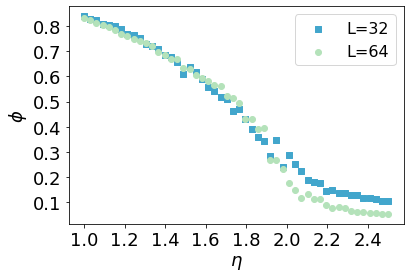

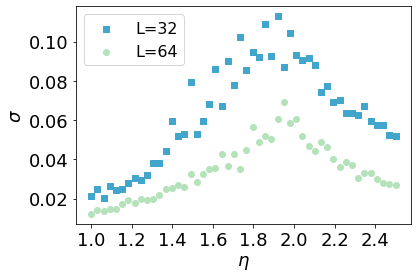

In [492]:


# plt.scatter(etas, np.mean(abs(np.mean(order_params_16,axis=-1)),axis=-1),color=colors[0],marker='^',label='L=16')
plt.scatter(etas, np.mean(abs(np.mean(order_params_32,axis=-1)),axis=-1),color=colors[1],marker='s',label='L=32')
plt.scatter(etas, np.mean(abs(np.mean(order_params_64,axis=-1)),axis=-1),color=colors[3],marker='o',label='L=64')
plt.legend(fontsize=16)
set_plot_basicinf(r'$\phi$',f'$\eta$',18)
plt.show()

# plt.scatter(etas, np.mean(abs(np.std(order_params_16,axis=-1)),axis=-1),color=colors[0],marker='^',label='L=16')
plt.scatter(etas, np.mean(abs(np.std(order_params_32,axis=-1)),axis=-1),color=colors[1],marker='s',label='L=32')
plt.scatter(etas, np.mean(abs(np.std(order_params_64,axis=-1)),axis=-1),color=colors[3],marker='o',label='L=64')
plt.legend(fontsize=16)
set_plot_basicinf('$\sigma$',f'$\eta$',18)
plt.show()


## self vs non-self

In [1155]:
'3  times experiments'
unself_losses = {}
self_losses = {}
eta = 1.75
for seed in [2050,2051,2053,2052,2054]:
    with open(f'./data/loss_unself_{seed}_L=32_eta={eta}.pkl','rb') as f:
        unself_losses[seed] = pkl.load(f)
        print(len(unself_losses[seed]['valid_loss']))
    with open(f'./data/loss_self_{seed}_L=32_eta={eta}.pkl','rb') as f:
        self_losses[seed] = pkl.load(f)
        print(len(self_losses[seed]['valid_loss']))
        print()

10
14

23
18

18
25

9
23

13
26



In [1170]:
colors = sns.color_palette('RdYlGn_r',6)
colors

[(0.2246828143021916, 0.6558246828143023, 0.34440599769319497),
 (0.6165321030372936, 0.8359092656670511, 0.41191849288735105),
 (0.8918877354863515, 0.954479046520569, 0.6010765090349867),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9873125720876587, 0.647366397539408, 0.36424452133794694),
 (0.8899653979238754, 0.28673587081891583, 0.19815455594002307)]

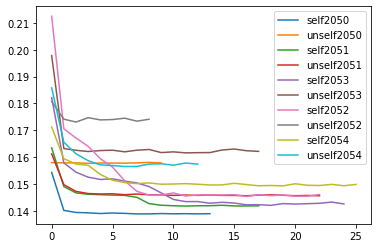

In [1171]:
for seed in [2050,2051,2053,2052,2054]:
    plt.plot(self_losses[seed]['valid_loss'],label=f'self{seed}')
    plt.plot(unself_losses[seed]['valid_loss'],label=f'unself{seed}')
plt.legend()




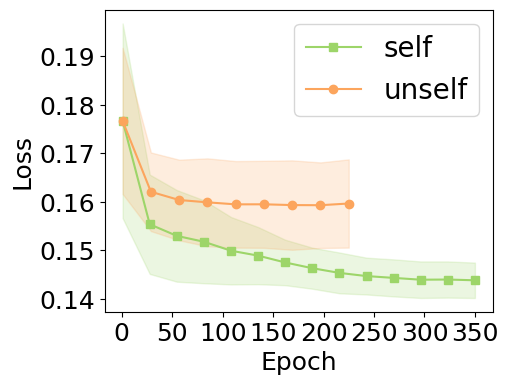

In [1176]:
plt.figure(dpi=100,figsize=(5,4))
fontsize=20
cut_time = 14
xx = np.linspace(1,cut_time*25,cut_time)

yy = np.array([i['valid_loss'][:cut_time] for i in self_losses.values()])
plt.plot(xx,np.mean(yy,axis=0),label='self',marker='s',color=colors[1])
plt.fill_between(xx,np.mean(yy,axis=0)-np.std(yy,axis=0),np.mean(yy,axis=0)+np.std(yy,axis=0),
                 color=colors[1],alpha=0.2)

cut_time = 9
xx = np.linspace(1,cut_time*25,cut_time)
yy = np.array([i['valid_loss'][:cut_time] for i in unself_losses.values()])
plt.plot(xx,np.mean(yy,axis=0),label='unself',marker='o',color=colors[4])
plt.fill_between(xx,np.mean(yy,axis=0)-np.std(yy,axis=0),np.mean(yy,axis=0)+np.std(yy,axis=0),
                 color=colors[4],alpha=0.2)
plt.legend(fontsize=fontsize)
set_plot_basicinf('Loss','Epoch',fontsize-2)
plt.show()

In [51]:
def set_plot_basicinf(ylabel,xlabel,fontsize=14):
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.xlabel(xlabel,fontsize=fontsize)